In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

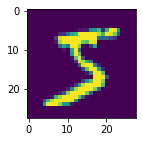

In [13]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [14]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(train_ds, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [15]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [16]:
def cnn_classifier():
    ks,stride = 3,2
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(4, 8, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 10, kernel_size=ks, stride=stride, padding=ks//2),
        nn.Flatten(),
    )

In [17]:
def linear_classifier():
    return nn.Sequential(
        Reshape((-1, 784)),
        nn.Linear(784, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )

In [18]:
model = linear_classifier()
lr = 0.1
max_lr = 0.1
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)

for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
        if train:
            sched.step()
        accuracy /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")
    

train, epoch:1, loss: 0.4002, accuracy: 0.7806
eval, epoch:1, loss: 0.2896, accuracy: 0.9007
train, epoch:2, loss: 0.2815, accuracy: 0.9171
eval, epoch:2, loss: 0.2144, accuracy: 0.9318
train, epoch:3, loss: 0.2128, accuracy: 0.9370
eval, epoch:3, loss: 0.1721, accuracy: 0.9435
train, epoch:4, loss: 0.1453, accuracy: 0.9489
eval, epoch:4, loss: 0.1629, accuracy: 0.9590
train, epoch:5, loss: 0.1110, accuracy: 0.9565
eval, epoch:5, loss: 0.1162, accuracy: 0.9681


In [6]:
# with open('./linear_classifier.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

In [4]:
from IPython.display import HTML, display, Image

In [34]:
%%html
<style>
    #whiteboard {
        border: 3px solid black;
        border-radius: 6px;  
        background-color: #FFFFFF;
    }
    #capture-button {
        background-color: #3F52D9; 
        color: white;
        border: none;
        padding: 10px 20px;
        cursor: pointer;
        font-size: 16px;
        border-radius: 3px;
        margin-top: 10px;
        width: 190px;
        margin-right: 20px;
    }
    #clear-button {
        background-color: #FF0000,; 
        color: black;
        border: none;
        padding: 10px 20px;
        cursor: pointer;
        font-size: 16px;
        border-radius: 3px;
        margin-top: 10px;
        width: 190px;
    }
    #container {
      display: flex;
      flex-direction: column; /* Arrange children vertically */
      align-items: center; /* Center horizontally */
      justify-content: center;
    }
    #btn-container {
      display: flex;
      flex-direction: row; /* Arrange children vertically */
      align-items: center; /* Center horizontally */
    }

</style>
<div id='container'>
<canvas id="whiteboard" width="400" height="200" fill_rect='white'></canvas>
<div id='btn-container'>
<button id="capture-button">Predict</button>
<button id="clear-button">Clear</button>
</div>

</div>
<script>
    var canvas = document.getElementById('whiteboard');
    var context = canvas.getContext('2d');
    var drawing = false;
    canvas.addEventListener('mousedown', function (e) {
        drawing = true;
        context.beginPath();
        context.moveTo(e.clientX - canvas.getBoundingClientRect().left, e.clientY - canvas.getBoundingClientRect().top);
    });
    canvas.addEventListener('mousemove', function (e) {
        if (drawing) {
            context.lineTo(e.clientX - canvas.getBoundingClientRect().left, e.clientY - canvas.getBoundingClientRect().top);
            context.stroke();
        }
    });
    canvas.addEventListener('mouseup', function () {
        drawing = false;
    });
    canvas.addEventListener('mouseout', function () {
        drawing = false;
    });
    
    var clearButton = document.getElementById('clear-button');
    clearButton.addEventListener('click', function () {
       context.clearRect(0, 0, canvas.width, canvas.height);
    });

   var captureButton = document.getElementById('capture-button');
    captureButton.addEventListener('click', function () {
       // Convert the canvas content to a data URL (image)
    var imageData = canvas.toDataURL("image/png");

    // Send the image data to the Jupyter kernel variable
    IPython.notebook.kernel.execute('image_data = "' + imageData + '"');
    });
</script>


In [36]:
import numpy as np
from PIL import Image
import io
import re
import base64
import torch

# Extract the base64 portion of the data URL
image_data_base64 = re.sub('^data:image/.+;base64,', '', image_data)

# Decode the base64 string to bytes and create a PIL Image
image_bytes = base64.b64decode(image_data_base64)
image = Image.open(io.BytesIO(image_bytes))

# Convert the PIL Image to a NumPy array
image_np = np.array(image)
image_tensor = torch.from_numpy(image_np)
image_tensor.shape

NameError: name 'image_data' is not defined